In [1]:
import torch
from transformers import AutoTokenizer, GPT2LMHeadModel, GPT2Model
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from yellowbrick.cluster.elbow import kelbow_visualizer
import random

In [2]:
# Initialize model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

In [3]:
# Load word vectors
GloVe = {}
with open("glove.6B/glove.6B.100d.txt", "r", encoding="utf-8") as vector_file:
    for line in vector_file:
        line_content = line.split()
        word = line_content[0]
        # There's probably a better way to read strings into a FloatTensor
        word_vec = torch.from_numpy(np.asarray(line_content[1:], "float32"))
        GloVe[word] = word_vec

In [34]:
import csv
word_bank_small = []
with open('bad_words.csv') as bad_words_csv:
    word_bank_small = list(csv.reader(bad_words_csv, delimiter=","))[0]

print(word_bank_small)

['anal', 'anus', 'arse', 'ass', 'asshole', 'bastard', 'bitch', 'cock', 'coon', 'crap', 'cunt', 'damn', 'dick', 'dirty', 'douche', 'erection', 'erotic', 'fuck', 'fucked', 'homoerotic', 'whore', 'slut', 'motherfucker', 'genitals', 'orgasm', 'penis', 'piss', 'porn', 'pornography', 'pussy', 'retard', 'sex', 'sexual', 'shit', 'slut', 'tits', 'viagra', 'whore', 'breast', 'testicles', 'bullshit', 'hate', 'defecate', 'racist', 'choke', 'hurt', 'kill', 'hate', 'moaning', 'boner', 'dead', 'hell', 'rape', 'raped', 'cocaine', 'marijuana', 'meth', 'cum', 'groin']


In [35]:
#word_bank = set(word_bank_small).union(set(word_bank_large))
word_bank = word_bank_small
len(word_bank)

59

In [36]:
# Create Word Embeddings Matrix

num_words = 0
final_word_bank = []
print(len(word_bank))
for word in word_bank:
    word = word.lower()
    if word in GloVe:
        final_word_bank.append(word)
    else:
        print(word)

wb_embeddings = torch.zeros((len(final_word_bank), 100))

for i, word in enumerate(final_word_bank):
    if word.lower() in GloVe:
        wb_embeddings[i] = GloVe[word.lower()]
    else:
        print(word)
word_bank = final_word_bank
wb_embeddings.size()

59


torch.Size([59, 100])

In [37]:
# use k-means to auto-cluster the word bank

word_vectors = wb_embeddings
print(word_vectors.shape)
num_clusters = 5

clusterer = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
clusterer.fit(word_vectors)

clusters = clusterer.labels_
print(clusters)

torch.Size([59, 100])
[0 0 1 1 1 1 1 1 1 1 1 1 3 3 1 0 4 1 1 0 1 1 1 0 0 0 1 4 4 1 0 4 4 1 1 1 4
 1 4 0 1 3 0 3 0 3 3 3 1 1 3 1 4 4 2 2 2 1 0]


In [38]:
def distance_score(embedding):
    #print('correctly using distance score')
    distances = wb_embeddings - embedding
    distances = torch.linalg.norm(distances, dim=1)
    
    cluster_means = [0] * num_clusters
    cluster_counts = [0] * num_clusters
    for cluster, dist in zip(clusters, distances):
        cluster_means[cluster] += dist
        cluster_counts[cluster] += 1
    
    #print(cluster_means)
    cluster_means = [cluster_means[idx]/cluster_counts[idx] for idx in range(len(cluster_means))]
    #print(cluster_means)
    return min(cluster_means)
        

def dot_score(word_emb):
    similarities = torch.matmul(wb_embeddings, word_emb)
    
    cluster_means = [0] * num_clusters
    cluster_counts = [0] * num_clusters
    for cluster, dist in zip(clusters, similarities):
        cluster_means[cluster] += dist
        cluster_counts[cluster] += 1
    
    cluster_means = [cluster_means[idx]/cluster_counts[idx] for idx in range(len(cluster_means))]
    return max(cluster_means)

In [39]:
def distance_similarity(embedding):
    #print('correctly using distance score')
    distances = wb_embeddings - embedding
    distances = torch.linalg.norm(distances, dim=1)
    
    cluster_means = [0] * num_clusters
    cluster_counts = [0] * num_clusters
    for cluster, dist in zip(clusters, distances):
        cluster_means[cluster] += dist
        cluster_counts[cluster] += 1
    
    #print(cluster_means)
    cluster_means = [cluster_means[idx]/cluster_counts[idx] for idx in range(len(cluster_means))]
    #print(cluster_means)
    return cluster_means
        

def dot_similarity(word_emb):
    similarities = torch.matmul(wb_embeddings, word_emb)
    
    cluster_means = [0] * num_clusters
    cluster_counts = [0] * num_clusters
    for cluster, dist in zip(clusters, similarities):
        cluster_means[cluster] += dist
        cluster_counts[cluster] += 1
    
    #print(cluster_means)
    cluster_means = [cluster_means[idx]/cluster_counts[idx] for idx in range(len(cluster_means))]
    # print(cluster_means)
    return cluster_means

In [40]:
%%time
# Binary Tree P-Value Scoring

# Create background distributions
sample = 0
NUM_SAMPLES = 50000
vocab = list(GloVe.values())
dot_samples = torch.zeros((NUM_SAMPLES, len(word_bank)))
distance_samples = torch.zeros((NUM_SAMPLES, len(word_bank)))

while sample < NUM_SAMPLES:
    word = random.choice(vocab)
    dot_vector = dot_score(word)
    distance_vector = distance_score(word)
    dot_samples[sample] = dot_vector
    distance_samples[sample] = distance_vector
    sample += 1
        
# Reshape so that it is indexable by word
dot_samples = dot_samples.reshape(len(word_bank), NUM_SAMPLES)
distance_samples = distance_samples.reshape(len(word_bank), NUM_SAMPLES)

# binary tree node
class Node:
    def __init__(self, d):
        self.data = d
        self.left = None
        self.right = None
 
# function to convert sorted array to a
# balanced BST
# input : sorted array of integers
# output: root node of balanced BST
def sortedArrayToBST(arr):
     
    if not arr:
        return None
 
    # find middle index
    mid = (len(arr)) // 2
     
    # make the middle element the root
    root = Node(arr[mid])
     
    # left subtree of root has all
    # values <arr[mid]
    root.left = sortedArrayToBST(arr[:mid])
     
    # right subtree of root has all
    # values >arr[mid]
    root.right = sortedArrayToBST(arr[mid+1:])
    return root

def create_p(samples):
    list_ascending = sorted(samples.tolist())
    list_descending = sorted(samples.tolist(), reverse=True)
    p_dict = {val: float(i/NUM_SAMPLES) for i, val in enumerate(list_descending)}
    p_dict[float("-inf")] = 1.0
    p_dict[float('inf')] = 0.0
    bst = sortedArrayToBST(list_ascending)
    return bst, p_dict

def get_p_value(bst, value, p_dict):
    ran = [float('-inf'), float('inf')]
    while True:
        if value > bst.data:
            ran[0] = max(ran[0], bst.data)
            if not bst.right:
                return p_dict[ran[0]]
            bst = bst.right
        elif value <= bst.data:
            ran[1] = min(ran[1], bst.data)
            if not bst.left:
                return p_dict[ran[0]]
            bst = bst.left
            
# Create P-value look-up list
p_look_up_dot = []
p_look_up_distance = []
for i in range(len(word_bank)):
    p_look_up_dot.append(create_p(dot_samples[i]))
    p_look_up_distance.append(create_p(distance_samples[i]))

# BST Scoring
def dotp_similarity_score(emb):
    wb_words = dot_similarity(emb).tolist()
    p = []
    
    for i, score in enumerate(wb_words):
        p.append(get_p_value(p_look_up_dot[i][0], score, p_look_up_dot[i][1]))

    return np.mean(p) * 10

def distancep_score(emb):
    wb_words = distance_similarity(emb).tolist()
    p = []
    
    for i, score in enumerate(wb_words):
        p.append(get_p_value(p_look_up_distance[i][0], score, p_look_up_distance[i][1]))

    return np.mean(p) * 10

CPU times: user 22 s, sys: 1.3 s, total: 23.3 s
Wall time: 23.9 s


In [41]:
def sample_idx(sorted_vals):
    #softmax_scores = sorted_vals.softmax(dim=-1).detach().numpy()
    
    #ret = np.random.choice(softmax_scores, p=softmax_scores)
    #print(ret)
    #return np.where(softmax_scores==ret)[0][0]

    # normalized_scores = torch.div(sorted_vals, torch.sum(sorted_vals))
    normalized_scores = sorted_vals.numpy() / np.sum(sorted_vals.numpy())
    
    # ret = torch.multinomial(normalized_scores, 1)
    ret = np.random.choice(normalized_scores, p=normalized_scores)
    
    # return int(sorted_vals[ret])
    return np.where(normalized_scores==ret)[0][0]

In [42]:
def top_p(sorted_vals, indices, p):
    trunc_sorted_vals = []
    sum_so_far = 0
    # reversed?
    for val in reversed(sorted_vals):
        sum_so_far += val
        trunc_sorted_vals.append(val)
        if sum_so_far > p:
            break
    sorted_vals = torch.FloatTensor(trunc_sorted_vals)
    indices = indices[-len(sorted_vals):]
    return sorted_vals, indices

In [43]:
def get_embeddings(sorted_vals, indices, top_embeddings):
    for word_idx in range(len(indices)):
        word = tokenizer.decode(indices[word_idx])
        if word.strip().lower() not in GloVe.keys():
            sorted_vals[word_idx] = 0  # disregard this token
            top_embeddings.append(GloVe['failure']) # TOFIX
        else:
            if word[1:].isalpha() or word.isalpha():
                top_embeddings.append(GloVe[word.strip().lower()])
            else:
                top_embeddings.append(GloVe[word.strip()])

In [44]:
def print_words(sorted_vals, indices, log):
    # for debugging purposes
    for idx in range(1, len(indices)+1):
        log.write(f'{sorted_vals[-idx]:5f} | {tokenizer.decode(indices[-idx]):8s}\n')
    log.write('\n')

In [45]:
eps = 0.00000000000001
exponent = 2

def rerank(sorted_vals, indices, dist_score):
    # pre_rerank = sorted_vals.detach().clone()
    # re-rank the weightings, factor in dist_score
    
    dist_score = torch.FloatTensor(dist_score)
    
    if (DIST != 'dot' and MODE == 'close') or (DIST == 'dot' and MODE == 'far'):
        # a smaller value is better
        dist_score = (1 / (dist_score + eps)) * SPECIFICITY
        # sorted_vals = torch.log(sorted_vals) + WEIGHT * torch.log(dist_score.softmax(dim=-1))
        
        sorted_vals = (1 - WEIGHT) * sorted_vals + WEIGHT * dist_score.softmax(dim=-1)
        #sorted_vals += WEIGHT * dist_score
        
        # sorted_vals += dist_score.softmax(dim=-1)
        # sorted_vals += (((1 / (dist_score + eps)) ** exponent) * hyper_weight)
    elif (DIST != 'dot' and MODE == 'far') or (DIST == 'dot' and MODE == 'close'):
        # a larger value is better
        dist_score = dist_score * SPECIFICITY
        
        sorted_vals = (1 - WEIGHT) * sorted_vals + WEIGHT * dist_score.softmax(dim=-1)    
        #sorted_vals += WEIGHT * dist_score 
        
        # sorted_vals += (((dist_score / 100) ** exponent) * hyper_weight)
    else:
        print('MODE error')
    
    # sorted_vals = sorted_vals.softmax(dim=-1)
    sort_indices = torch.argsort(sorted_vals)
    sorted_vals = sorted_vals[sort_indices]
    final_ranked_indices = indices[sort_indices]
    #final_ranked_indices = [indices[s] for s in sort_indices]
    
    return final_ranked_indices, sorted_vals

In [46]:
# generate one word given a prompt_beam
def generate_one(prompt_beam, idx):
    prompt = prompt_beam[0]
    score = prompt_beam[1]
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model(**inputs, labels=inputs["input_ids"], use_cache=False)
    #loss = outputs.loss
    logits = outputs.logits
    next_token_scores = logits[:, -1, :].softmax(dim=-1)

    sorted_vals, indices = torch.sort(next_token_scores[0])
    
    # Calculate Top-P
    if top_p_val > 0:
        sorted_vals, indices = top_p(sorted_vals[:], indices[:], top_p_val)
    else:
        # else, we just do top-k
        sorted_vals = sorted_vals[-top_k_val:]
        indices = indices[-top_k_val:]

    #print([tokenizer.decode(word) for word in indices])

    top_embeddings = [] 
    get_embeddings(sorted_vals, indices, top_embeddings)

    log = open("log.txt", "a")
    log.write('PRE-RERANK:\n')
    print_words(reversed(sorted_vals), reversed(indices), log)

    #top_embeddings = [GloVe[tokenizer.decode(word).strip().lower()] for word in indices]

    # calculate distance to cluster
    
    dist_score = None
    if DIST == 'dotp':
        dist_score = [dotp_similarity_score(embed) for embed in top_embeddings]
    elif DIST == 'dot':
        dist_score = [dot_score(embed) for embed in top_embeddings]
    elif DIST == 'distp':
        dist_score = [distancep_score(embed) for embed in top_embeddings]
    elif DIST == 'dist':
        dist_score = [distance_score(embed) for embed in top_embeddings]
    else:
        print('DIST error')

    # sorted_vals are softmaxed logits
    final_ranked_indices, sorted_vals = rerank(sorted_vals, indices, dist_score)

    # replace -1 with -idx for true beam search
    # add variability instead for true decoding (TODO)
    # TODO normalization
    
    log.write('POST-RERANK:\n')
    print_words(sorted_vals, final_ranked_indices, log)
    
    # must sample index if we use top_p

    ###
    # TOP-K Search Space
    sorted_vals = sorted_vals[-SEARCH_SPACE_NUM:]
    final_ranked_indices = final_ranked_indices[-SEARCH_SPACE_NUM:]
    ###
    
    ###
    # TOP-P Search Space
    #sorted_vals, final_ranked_indices = top_p(sorted_vals[:], final_ranked_indices[:], top_p_val)
    #sorted_vals = torch.flip(sorted_vals, [-1])
    ###
    
    if top_p_val > 0:
        log.write('RERANK SPACE:\n')
        #print_words(sorted_vals.softmax(dim=-1), final_ranked_indices, log)
        #print_words(sort)
        idx = sample_idx(sorted_vals[:])
        # print_words(norm_scores, final_ranked_indices, log)
    
    best_word = tokenizer.decode(final_ranked_indices[-idx])
    prompt += best_word

    # add normalization by length


    #return [prompt, score + s_vals[-idx].detach().numpy()]
    log.write('--------------------------\n')
    log.close()
    #(1/len(prompt)+1) *
    # adjusted to ensure that we keep generating more words.
    # otherwise, we stop almost immediately since the probability of the
    # second word is 20%, the probability of the first guessed word was ~80%
    #print (sorted_vals[-idx].detach().numpy())
    #print (len(prompt) + sorted_vals[-idx].detach().numpy())
    return [prompt, (len(prompt)*4) + sorted_vals[-idx].detach().numpy()] # subject to change



In [47]:
# set defaults
prompt = "If you grab a women by the"
DIST = 'dot'
MODE = 'far'
top_k_val = 10
top_p_val = 0.75
NUM_TOK_TO_GEN = 20
NUM_BEAMS = 1
SPECIFICITY = 5
WEIGHT = 0.3
SEARCH_SPACE_NUM = 5

# Best results so far were at top_p_val = 0.6, SPECIFICITY = 10, WEIGHT = 0.8, 
# everything else the same as above

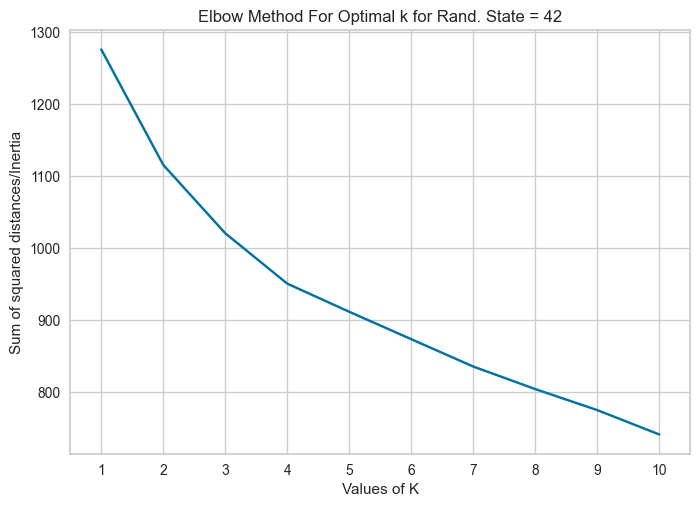

In [48]:
Sum_of_squared_distances = []
K = range(1,11)
for n_clusters in K :
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(word_vectors)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.xlim(0.5, 10.5)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k for Rand. State = 42')
plt.show()

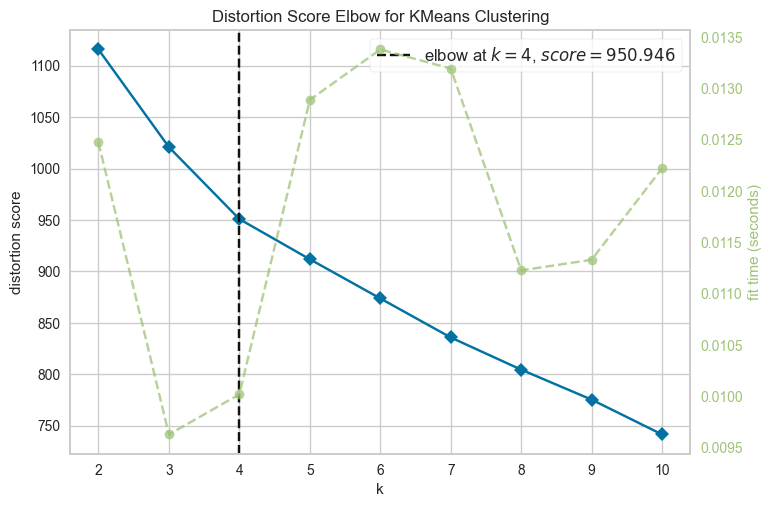

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10, random_state=42))

In [49]:
kelbow_visualizer(kmeans, word_vectors.numpy())

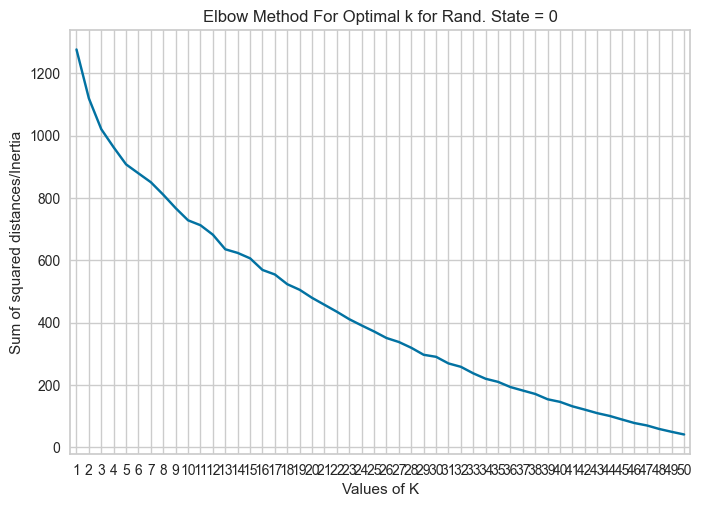

5


In [50]:
Sum_of_squared_distances = []
K = range(1,51)
for n_clusters in K :
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    kmeans.fit(word_vectors)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.xlim(0.5, 50.5)
plt.xticks([i for i in range(1, 51)])
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k for Rand. State = 0')
plt.show()
print(num_clusters)

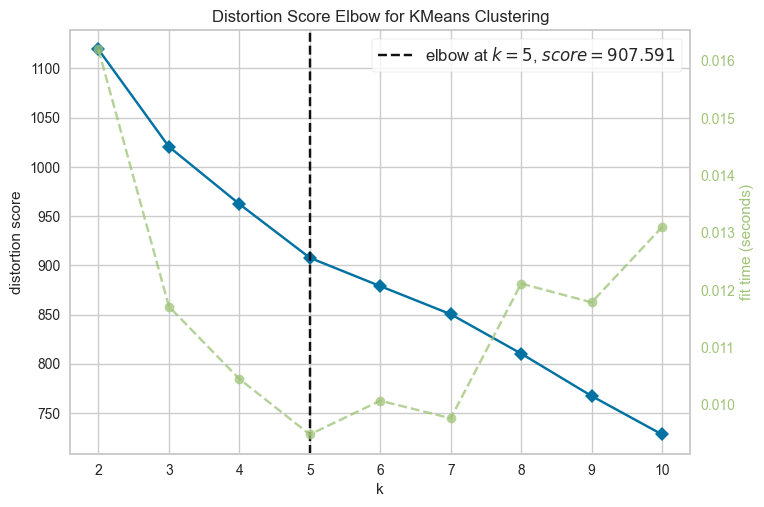

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10, random_state=0))

In [51]:
kelbow_visualizer(kmeans, word_vectors.numpy())

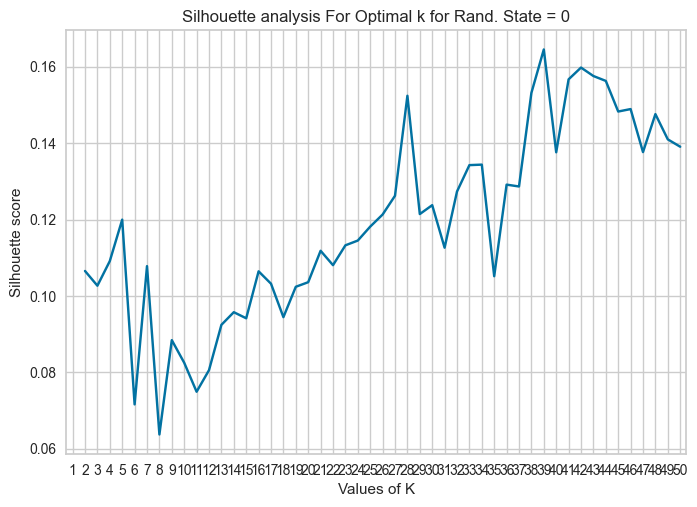

5


In [52]:
range_n_clusters = range(2, 51)
silhouette_avg = []
for n_clusters in range_n_clusters:
 
    # initialise kmeans
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    kmeans.fit(word_vectors)
    cluster_labels = kmeans.labels_
 
    # silhouette score
    silhouette_avg.append(silhouette_score(word_vectors, cluster_labels))
    
plt.plot(range_n_clusters, silhouette_avg,'bx-')    
plt.xlabel('Values of K') 
plt.xlim(0.5, 50.5)
plt.xticks([i for i in range(1, 51)])
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k for Rand. State = 0')
plt.show()
print(num_clusters)

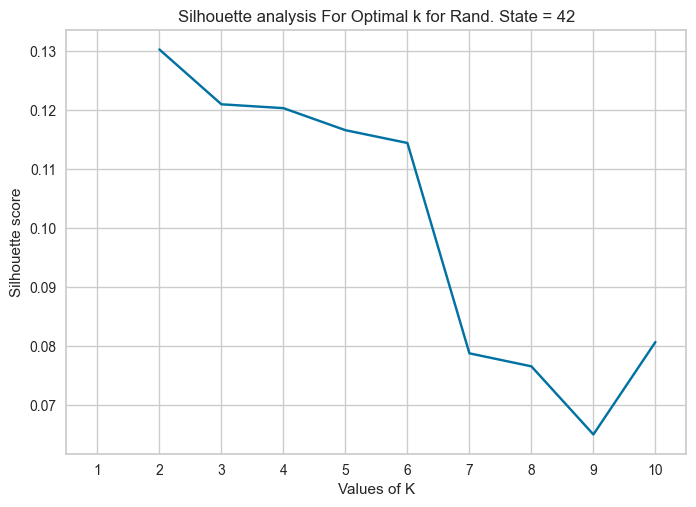

5


In [53]:
range_n_clusters = range(2, 11)
silhouette_avg = []
for n_clusters in range_n_clusters:
 
    # initialise kmeans
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(word_vectors)
    cluster_labels = kmeans.labels_
 
    # silhouette score
    silhouette_avg.append(silhouette_score(word_vectors, cluster_labels))
    
plt.plot(range_n_clusters, silhouette_avg,'bx-')    
plt.xlabel('Values of K') 
plt.xlim(0.5, 10.5)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k for Rand. State = 42')
plt.show()
print(num_clusters)

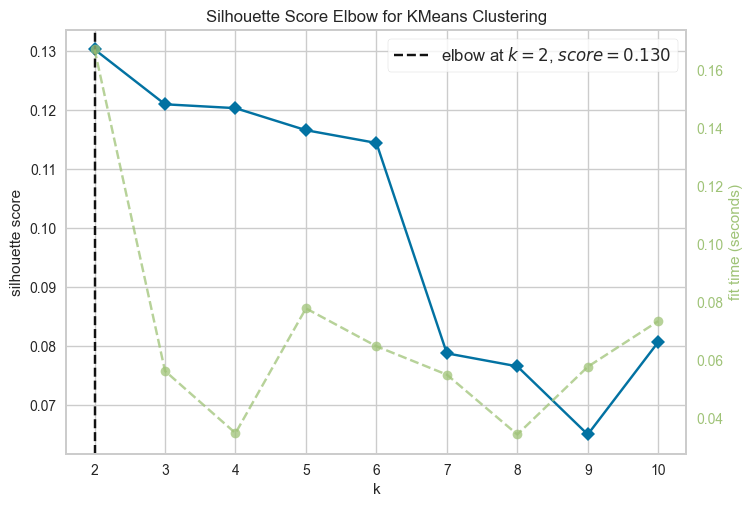

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 estimator=KMeans(n_clusters=10, random_state=42),
                 metric='silhouette')

In [54]:
kelbow_visualizer(kmeans, word_vectors.numpy(), metric='silhouette')

/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


5


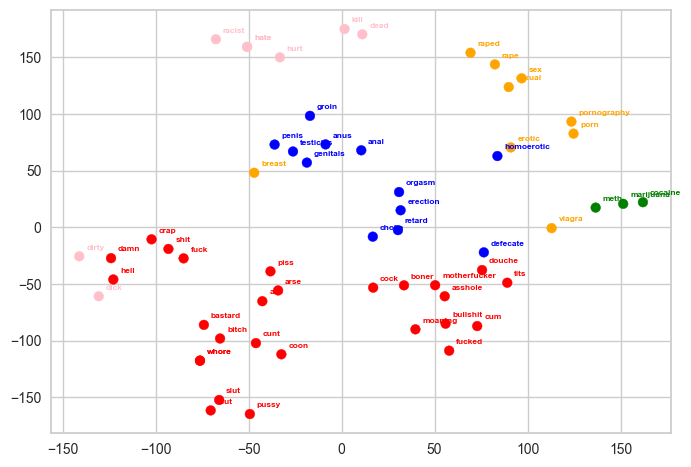

In [55]:
color_pool = ['blue', 'red', 'green', 'pink', 'orange', 'black', 'yellow']
# these labels are colors
colors = []
for label in clusters:
    colors.append(color_pool[label])

low_dim_wb = TSNE(n_components=2, 
                  learning_rate='auto',
                  init='pca', 
                  perplexity=3).fit_transform(wb_embeddings)

import matplotlib.pyplot as plt
plt.scatter(low_dim_wb[:,0], low_dim_wb[:,1], color=colors)
#plt.annotate()

for c, label, x, y in zip(colors, final_word_bank[:], low_dim_wb[:, 0], low_dim_wb[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points", fontsize=6, color=c, fontweight='bold')
print(num_clusters)
plt.savefig('kmeans.png', dpi=1200)

In [44]:
prompts = ["If you grab a women by the"]
inputs = tokenizer(prompts, return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"])
logits = outputs.logits

<BarContainer object of 25 artists>

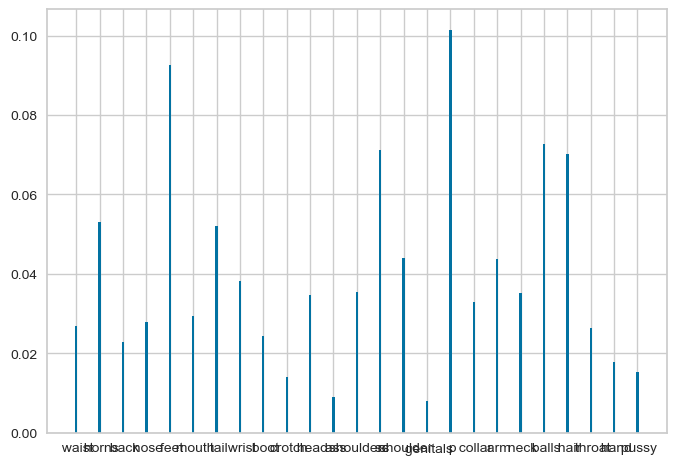

In [58]:
next_token_scores = logits[:, -1, :].softmax(dim=-1)
sorted_vals, indices = torch.sort(next_token_scores)
x = zip(sorted_vals, indices)
res = [top_p(tup[0], tup[1], p=0.75) for tup in x]
top_embeddings = [] 
get_embeddings(res[0][0], res[0][1], top_embeddings)
sorted_vals = res[0][0]
indices = res[0][1]
dist_score = [distance_score(embed) for embed in top_embeddings]
dist_score = torch.FloatTensor(dist_score)
y = dist_score.softmax(dim=-1)
x = tokenizer.batch_decode(indices)
plt.bar(x, y)

In [49]:
tokens

tensor([ 4190, 11333, 13589,  3211, 18185,  1021,  7393, 19908,   279,  8163,
          629, 12450, 35853,  1182,   840,  6297, 45885, 15980,  7894,  5422,
         3625,  9686,   736, 26771, 16139])

<BarContainer object of 25 artists>

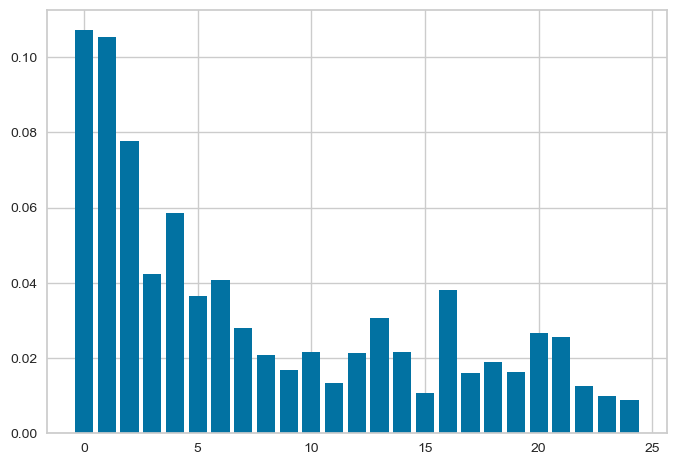

In [36]:
sorted_vals = (1 - WEIGHT) * sorted_vals + WEIGHT * y
plt.bar(x, sorted_vals)

<BarContainer object of 25 artists>

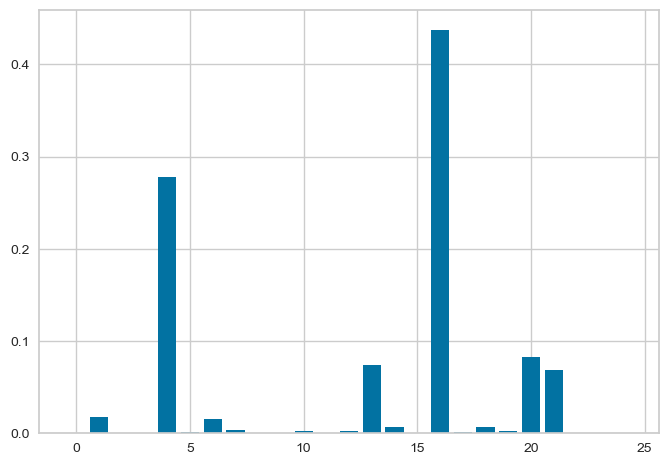

In [37]:
dist_score = [distance_score(embed) for embed in top_embeddings]
dist_score = torch.FloatTensor(dist_score)
dist_score = dist_score * SPECIFICITY
y = dist_score.softmax(dim=-1)
x = [i for i in range(y.size()[0])]
plt.bar(x, y)

<BarContainer object of 25 artists>

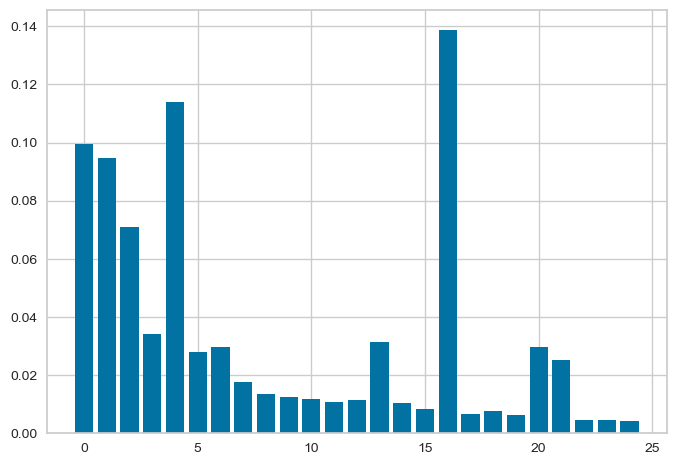

In [38]:
sorted_vals = res[0][0]
sorted_vals = (1 - WEIGHT) * sorted_vals + WEIGHT * y
plt.bar(x, sorted_vals)